### Imports

In [8]:
import torch
import torch.nn as nn # Neural Network
import torch.optim as optim # optimization module, which contains optimization algorithms like SGD, Adam, etc., used to update model parameters during training.
import torch.nn.functional as F # Imports functional operations in neural networks (like activation functions, loss functions, etc.)
from torch.utils.data import DataLoader, Dataset # Imports DataLoader and Dataset classes, which are used to load, process, and iterate over datasets efficiently 

### Tokenizer

In [5]:
class SimpleTokenizer:
    def __init__(self, vocab):
        self.word2idx = {word: idx for idx, word in enumerate(vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
    
    def encode(self, text):
        return [self.word2idx[word] for word in text.split() if word in self.word2idx]
    
    def decode(self, tokens):
        return ' '.join([self.idx2word[token] for token in tokens])

vocab = ["this", "is", "an", "example", "of", "language", "model", "training", "<PAD>", "<UNK>"]
tokenizer = SimpleTokenizer(vocab)

In [29]:
# Example sentence to encode
# text = "this is an example"
text = "language of training"

# Encode the text into tokens (indices)
encoded = tokenizer.encode(text)
print(f"Encoded: {encoded}")

# Decode the tokens back into the sentence
decoded = tokenizer.decode(encoded)
print(f"Decoded: {decoded}")

Encoded: [5, 4, 7]
Decoded: language of training


### Dataset - token generation

In [16]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = self.tokenizer.encode(self.texts[idx])
        tokens = tokens[:self.max_length] + [0] * (self.max_length - len(tokens))
        return torch.tensor(tokens), torch.tensor(tokens[1:] + [0])  # Input and shifted target
 
# Example dataset
texts = ["this is an example", "language model training"]
dataset = TextDataset(texts, tokenizer, max_length=10) # max-length can be varied depending on infra and data set size 256/512/1024/2048
dataloader = DataLoader(dataset, batch_size=2) # batch size - 4 to 64 if GPU, 128-512 if TPU

### Transformer Block

In [17]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, embed_size * 4),
            nn.ReLU(),
            nn.Linear(embed_size * 4, embed_size)
        )
    
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)
        ff_output = self.feed_forward(x)
        out = self.norm2(x + ff_output)
        return out

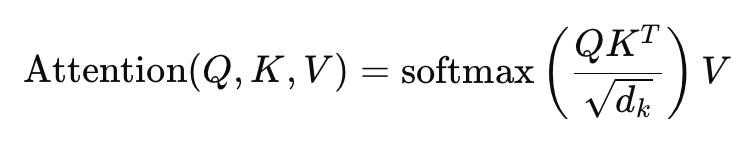

In [26]:
from IPython.display import Image
Image(filename='/Users/1392/Desktop/Screenshot 2025-02-07 at 8.01.11 AM.png')

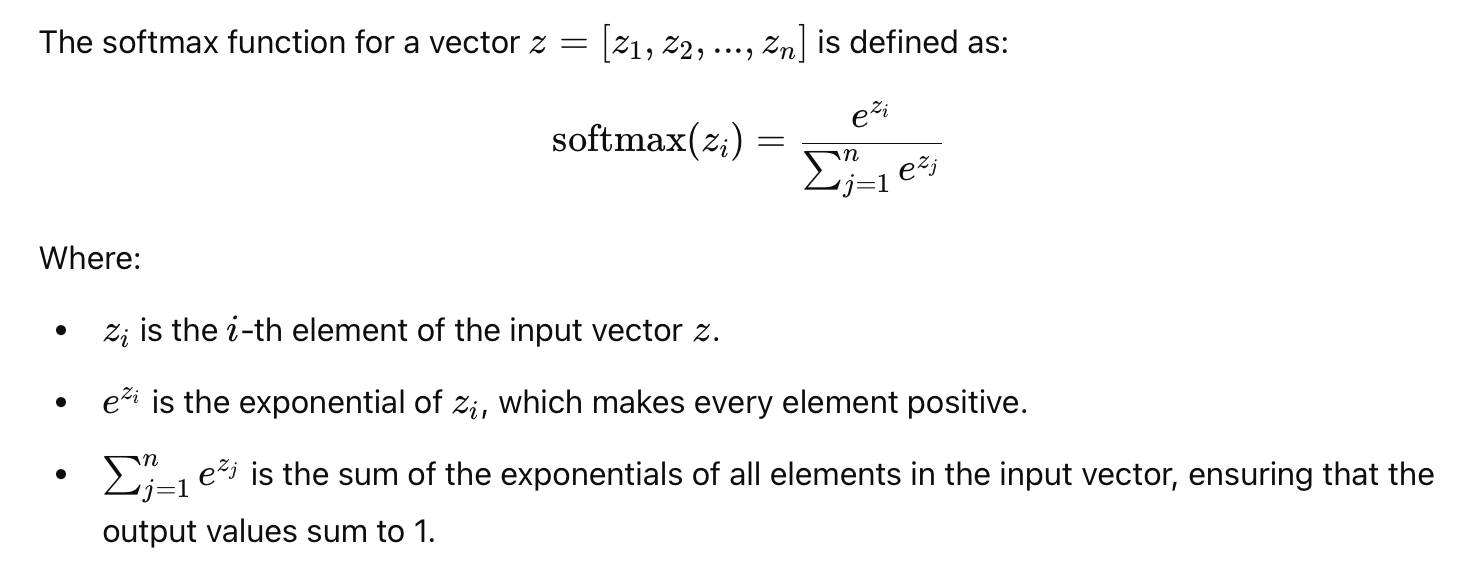

In [27]:
from IPython.display import Image
Image(filename='/Users/1392/Desktop/Screenshot 2025-02-07 at 8.05.06 AM.png')

### LLM Model (Stacking transformer blocks)

In [18]:
class LLM(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers):
        super(LLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.layers = nn.ModuleList([TransformerBlock(embed_size, num_heads) for _ in range(num_layers)])
        self.fc_out = nn.Linear(embed_size, vocab_size)
    
    def forward(self, x):
        out = self.embedding(x)
        out = out.transpose(0, 1)  # Required for multi-head attention
        for layer in self.layers:
            out = layer(out)
        out = out.transpose(0, 1)  # Revert back to batch-first
        out = self.fc_out(out)
        return out

### Training

In [19]:
def train_model(model, dataloader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for x, y in dataloader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} Loss: {loss.item()}")
 
# Initialize the model
model = LLM(vocab_size=len(vocab), embed_size=128, num_heads=4, num_layers=2)

# Train the model
train_model(model, dataloader, epochs=5)

Epoch 1 Loss: 2.374891996383667
Epoch 2 Loss: 0.9558106660842896
Epoch 3 Loss: 0.7428134679794312
Epoch 4 Loss: 0.5986372232437134
Epoch 5 Loss: 0.4502333700656891


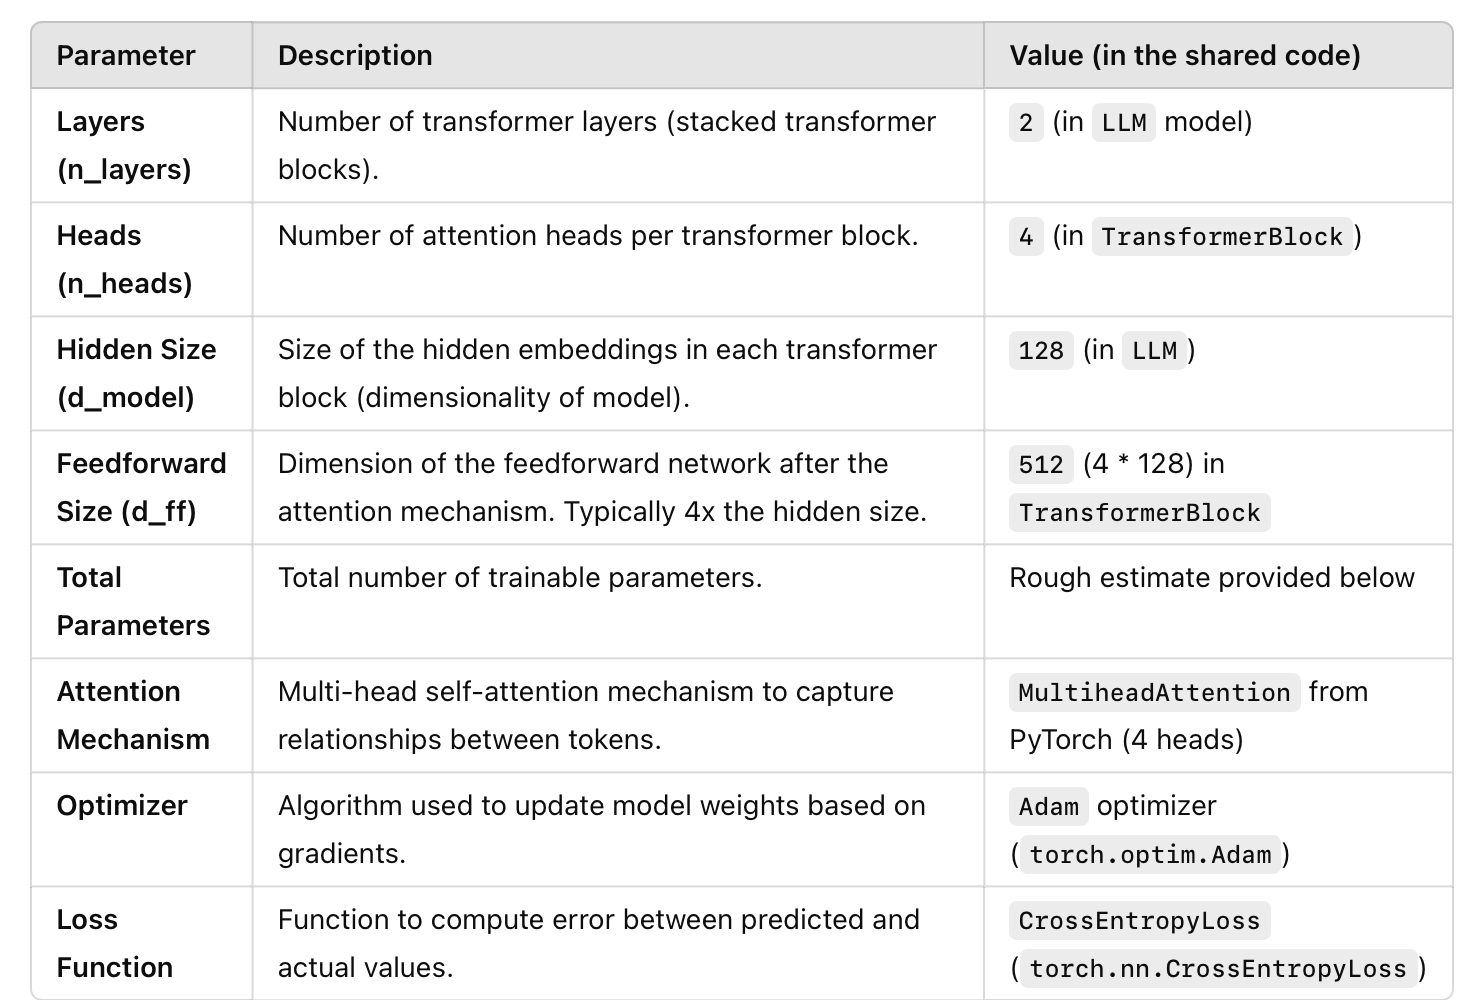

In [7]:
from IPython.display import Image
Image(filename='/Users/1392/Desktop/Screenshot 2025-02-06 at 2.32.10 PM.png')

In [ ]:
Model evaluation
Hyperparameter tuning
Model Inference
Fine tuning 
